In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import os
import scipy.io
plt.style.use("default")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

In [2]:
study_path = 'simu7_data/simu7_study/'
test_path = 'simu7_data/simu7_test/'
files = os.listdir(study_path)  # same name in test path
nitems = 24
npairs = 12

In [3]:
df = pd.DataFrame()
for f in files:
    
    # load subject data
    subjnum = int(f.lstrip('subj').rstrip('.mat'))
    study_mat = scipy.io.loadmat(os.path.join(study_path,f))['studymatrix']
    test_mat = scipy.io.loadmat(os.path.join(test_path,f))['theinfomatrix']
    nlists = study_mat.shape[-1]

    # get item's list and pos
    study_items_flat = study_mat.flatten(order='F')
    list_ids = np.repeat(np.arange(1, nlists + 1), nitems)
    list_pos = np.tile(np.arange(1, npairs + 1), nlists*2)
    item2list = {}
    item2pos = {}
    for i, item in enumerate(study_items_flat):
        item2list[item] = list_ids[i]
        item2pos[item] = list_pos[i]

    # reshape test mat
    for i in range(nlists):
        if i == 0:
            test_2d = test_mat[:,:,0]
        else:
            test_2d = np.concatenate((test_2d,test_mat[:,:,i]),axis=0)
    tmp_df = pd.DataFrame(test_2d)
    tmp_df.columns = ['test_item','response','pair_pos','lag','forward','correct','intrusion_type','rt']
    tmp_df['subjnum'] = subjnum
    tmp_df['list'] = np.repeat(np.arange(1,nlists+1),npairs)

    # get response type
    def get_intrusion_type(x):
        correctness = x['correct']
        response = x['response']
        if correctness == 1:
            return 'Correct'
        else:
            if response == 99999 or response == -99999 or (response not in study_items_flat) or response == x['test_item']:
                return 'Out'
            else:
                resp_list = item2list[response]
                if resp_list == x['list']:
                    return 'ILI'
                elif resp_list < x['list']:
                    return 'PLI'
                else:
                    return 'Out'
    tmp_df['type'] = tmp_df.apply(get_intrusion_type, axis=1)

    # get response pos
    def get_resp_pos(x):
        resp_type = x['type']
        if resp_type == "Correct":
            return item2pos[x['response']]
            # return x['pair_pos']
        elif resp_type == 'ILI':
            return item2pos[x['response']]
        else:
            return None
    tmp_df['resp_pos'] = tmp_df.apply(get_resp_pos, axis=1)

    # get response list
    def get_resp_list(x):
        resp_type = x['type']
        if resp_type == "Correct" or resp_type == "ILI":
            return x['list']
        elif resp_type == "PLI":
            return item2list[x['response']]
        else:
            return None
    tmp_df['resp_list'] = tmp_df.apply(get_resp_list, axis=1)

    df = pd.concat([df,tmp_df])
df

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list
0,41.0,14.0,12.0,0.0,0.0,1.0,0.0,185.0,1,1,Correct,12.0,1.0
1,248.0,31.0,8.0,-4.0,0.0,1.0,0.0,2971.0,1,1,Correct,8.0,1.0
2,78.0,74.0,6.0,-2.0,1.0,1.0,0.0,742.0,1,1,Correct,6.0,1.0
3,321.0,155.0,7.0,1.0,0.0,1.0,0.0,0.0,1,1,Correct,7.0,1.0
4,134.0,157.0,10.0,3.0,1.0,1.0,0.0,742.0,1,1,Correct,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,146.0,105.0,5.0,1.0,1.0,1.0,0.0,370.0,9,15,Correct,5.0,15.0
176,410.0,99999.0,3.0,-2.0,1.0,0.0,0.0,14674.0,9,15,Out,NaN,NaN
177,163.0,105.0,9.0,6.0,0.0,0.0,1.0,7986.0,9,15,ILI,5.0,15.0
178,279.0,253.0,4.0,-5.0,1.0,1.0,0.0,0.0,9,15,Correct,4.0,15.0


In [4]:
# pos_lag and list_lag
df['pos_lag'] = df['resp_pos'] - df['pair_pos']
df['list_lag'] = df['resp_list'] - df['list']
df

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
0,41.0,14.0,12.0,0.0,0.0,1.0,0.0,185.0,1,1,Correct,12.0,1.0,0.0,0.0
1,248.0,31.0,8.0,-4.0,0.0,1.0,0.0,2971.0,1,1,Correct,8.0,1.0,0.0,0.0
2,78.0,74.0,6.0,-2.0,1.0,1.0,0.0,742.0,1,1,Correct,6.0,1.0,0.0,0.0
3,321.0,155.0,7.0,1.0,0.0,1.0,0.0,0.0,1,1,Correct,7.0,1.0,0.0,0.0
4,134.0,157.0,10.0,3.0,1.0,1.0,0.0,742.0,1,1,Correct,10.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,146.0,105.0,5.0,1.0,1.0,1.0,0.0,370.0,9,15,Correct,5.0,15.0,0.0,0.0
176,410.0,99999.0,3.0,-2.0,1.0,0.0,0.0,14674.0,9,15,Out,NaN,NaN,NaN,NaN
177,163.0,105.0,9.0,6.0,0.0,0.0,1.0,7986.0,9,15,ILI,5.0,15.0,-4.0,0.0
178,279.0,253.0,4.0,-5.0,1.0,1.0,0.0,0.0,9,15,Correct,4.0,15.0,0.0,0.0


### PLI

In [5]:
# all PLIs
df.query("type == 'PLI'")

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
18,164.0,41.0,11.0,-1.0,1.0,0.0,-1.0,2785.0,1,2,PLI,NaN,1.0,NaN,-1.0
116,363.0,388.0,3.0,1.0,1.0,0.0,-1.0,3157.0,1,10,PLI,NaN,9.0,NaN,-1.0
67,194.0,276.0,1.0,-1.0,0.0,0.0,-1.0,185.0,10,6,PLI,NaN,4.0,NaN,-2.0
38,212.0,112.0,2.0,1.0,1.0,0.0,-1.0,5406.0,100,4,PLI,NaN,3.0,NaN,-1.0
44,212.0,112.0,2.0,-9.0,1.0,0.0,-1.0,4100.0,100,4,PLI,NaN,3.0,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,272.0,440.0,2.0,1.0,0.0,0.0,-1.0,2228.0,9,13,PLI,NaN,8.0,NaN,-5.0
157,277.0,192.0,2.0,-3.0,1.0,0.0,-1.0,0.0,9,14,PLI,NaN,10.0,NaN,-4.0
162,280.0,327.0,1.0,-8.0,1.0,0.0,-1.0,2971.0,9,14,PLI,NaN,8.0,NaN,-6.0
168,281.0,292.0,7.0,0.0,0.0,0.0,-1.0,7429.0,9,15,PLI,NaN,9.0,NaN,-6.0


In [6]:
df_PLI = df.query("type == 'PLI' and list > 5 and  -6 < list_lag")
# df_PLI = df.query("type == 'PLI' and  list > 1 and -6 < list_lag < 0")
# df_PLI = df.query("type == 'PLI' and  list > 1 and list_lag < 0")
# df_PLI = df.query("type == 'PLI' and list > 5 and  list_lag < 0")
df_PLI

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
116,363.0,388.0,3.0,1.0,1.0,0.0,-1.0,3157.0,1,10,PLI,NaN,9.0,NaN,-1.0
67,194.0,276.0,1.0,-1.0,0.0,0.0,-1.0,185.0,10,6,PLI,NaN,4.0,NaN,-2.0
72,73.0,117.0,3.0,0.0,0.0,0.0,-1.0,1116.0,100,7,PLI,NaN,3.0,NaN,-4.0
161,369.0,354.0,8.0,7.0,1.0,0.0,-1.0,2421.0,100,14,PLI,NaN,9.0,NaN,-5.0
67,133.0,39.0,10.0,1.0,1.0,0.0,-1.0,8576.0,104,6,PLI,NaN,4.0,NaN,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,21.0,178.0,3.0,0.0,1.0,0.0,-1.0,1856.0,9,9,PLI,NaN,8.0,NaN,-1.0
140,115.0,327.0,12.0,4.0,1.0,0.0,-1.0,10216.0,9,12,PLI,NaN,8.0,NaN,-4.0
143,373.0,327.0,8.0,4.0,0.0,0.0,-1.0,2971.0,9,12,PLI,NaN,8.0,NaN,-4.0
146,272.0,440.0,2.0,1.0,0.0,0.0,-1.0,2228.0,9,13,PLI,NaN,8.0,NaN,-5.0


In [7]:
len(np.unique(df_PLI.subjnum))

42

In [8]:
PLI_num = df_PLI.shape[0]
df_PLIgp = df_PLI.groupby("list_lag")['test_item'].count().to_frame(name='PLI_cnt').reset_index()
df_PLIgp['list_abs_lag'] = np.abs(df_PLIgp['list_lag'])
df_PLIgp['PLI_prob'] = df_PLIgp['PLI_cnt'] / PLI_num
df_PLIgp

,list_lag,PLI_cnt,list_abs_lag,PLI_prob
0,-5.0,11,5.0,0.106796
1,-4.0,25,4.0,0.242718
2,-3.0,15,3.0,0.145631
3,-2.0,25,2.0,0.242718
4,-1.0,27,1.0,0.262136


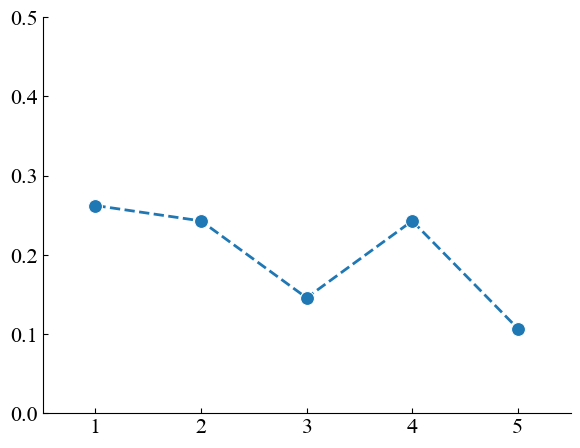

In [17]:
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_PLIgp.query("list_abs_lag < 6"), x='list_abs_lag', y='PLI_prob', linewidth=2, marker='o', markersize = 10, linestyle = '--')
plt.ylim([0,0.5])
plt.xlim([0.5,5.5])
plt.xticks(ticks=np.arange(1,6))
plt.yticks(ticks=np.arange(0,0.6,0.1),labels=np.arange(0,0.6,0.1).round(decimals=2))
plt.xlabel('Lag')
plt.ylabel('PLI Probablility')
ax.set(xlabel=None, ylabel=None)

plt.savefig('simu7_fig/simu7_Davis_PLI.pdf')
plt.show()

### ILI

In [10]:
df_ILI = df.query("type == 'ILI' and list > 1")
df_ILI

,test_item,response,pair_pos,lag,forward,correct,intrusion_type,rt,subjnum,list,type,resp_pos,resp_list,pos_lag,list_lag
19,49.0,61.0,10.0,-1.0,1.0,0.0,1.0,29349.0,1,2,ILI,8.0,2.0,-2.0,0.0
96,411.0,413.0,7.0,0.0,1.0,0.0,1.0,13559.0,1,9,ILI,12.0,9.0,5.0,0.0
61,6.0,278.0,6.0,-1.0,0.0,0.0,1.0,370.0,10,6,ILI,8.0,6.0,2.0,0.0
169,433.0,224.0,10.0,-1.0,1.0,0.0,1.0,0.0,10,15,ILI,8.0,15.0,-2.0,0.0
149,231.0,235.0,9.0,4.0,1.0,0.0,1.0,12120.0,100,13,ILI,12.0,13.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,113.0,373.0,4.0,2.0,1.0,0.0,1.0,3528.0,9,12,ILI,8.0,12.0,4.0,0.0
156,363.0,39.0,5.0,0.0,0.0,0.0,1.0,185.0,9,14,ILI,12.0,14.0,7.0,0.0
158,283.0,179.0,3.0,1.0,0.0,0.0,1.0,0.0,9,14,ILI,8.0,14.0,5.0,0.0
167,283.0,265.0,3.0,-2.0,0.0,0.0,1.0,2971.0,9,14,ILI,5.0,14.0,2.0,0.0


In [11]:
possible_ILI_cnt = {}
for pair_pos in df_ILI.pair_pos:
    l_bound = -pair_pos + 1
    r_bound = 12 - pair_pos
    for i in np.arange(l_bound, r_bound + 1):
        if i in possible_ILI_cnt:
            possible_ILI_cnt[i] += 1
        else:
            possible_ILI_cnt[i] = 1
# possible_ILI_cnt

In [12]:
df_ILIgp = df_ILI.groupby("pos_lag")['test_item'].count().to_frame(name='ILI_cnt')
df_ILIgp['poss_ILI_cnt'] = pd.Series(possible_ILI_cnt)
df_ILIgp['ILI_prob'] = df_ILIgp['ILI_cnt'] / df_ILIgp['poss_ILI_cnt']
df_ILIgp

,ILI_cnt,poss_ILI_cnt,ILI_prob
pos_lag,,,
-11.0,5,45,0.111111
-10.0,12,97,0.123711
-9.0,9,147,0.061224
-8.0,8,192,0.041667
-7.0,10,243,0.041152
-6.0,15,294,0.051020
-5.0,19,351,0.054131
-4.0,37,398,0.092965
-3.0,27,442,0.061086


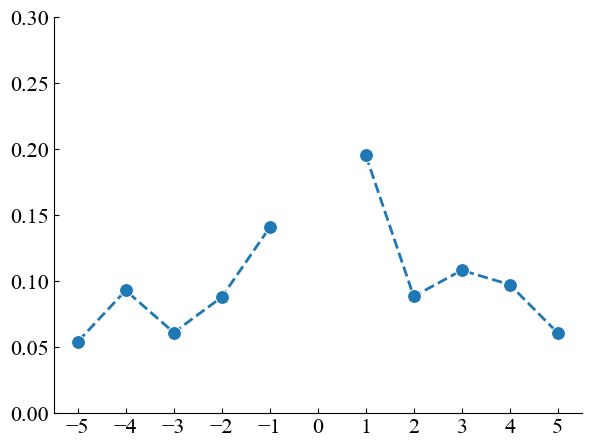

In [13]:
fig, ax = plt.subplots(figsize=(6,4.5))
fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")

sns.lineplot(data=df_ILIgp.query("-6 < pos_lag < 0"), x='pos_lag', y='ILI_prob', linewidth=2, marker='o', markersize = 10,color='C0', linestyle = '--')
sns.lineplot(data=df_ILIgp.query("0 < pos_lag < 6"), x='pos_lag', y='ILI_prob', linewidth=2, marker='o', markersize = 10,color='C0', linestyle = '--')
plt.ylim([0,0.3])
plt.xticks(ticks=np.arange(-5,6))
plt.xlabel('Lag')
plt.ylabel('Intrusion Conditional Response Probablility')
ax.set(xlabel=None, ylabel=None)

plt.savefig('simu7_fig/simu7_Davis_ILI.pdf')
plt.show()